# Example: Least Squares Fit with Scipy
 >__Created__:  25 June 2018 Harrison B. Prosper, ESHEP 18, Maratea, Italy
 
 
 This notebook gives a basic introduction to __Python__ and least squares fitting using __scipy__. It is an implementation of part of Glen Cowan's exercise at INFN SOS 2013, Vietri sul Mare, Italy. Updated June 4 at INFN SOS 2019.
 
 ### Python Tips
  * Python uses indentation to create program blocks.
    Semicolons are not needed as in C++. It is therefore convenient to use
    a Python-aware editor, such as __emacs__. This will help
    minimize indentation errors.

  * There are two basic ways to load program modules into memory, e.g.:

          import os
    and
          from string import replace
          
    Also note
    
          import numpy as np

  * Strings can be initialized either with single or double quotes,
    'ABC' or "ABC". This is useful when "ABC" needs to be embedded within
    a string. Use \ to continue strings across lines: 

            poem = 'You blocks you stones\n'\
                   'You worse than senseless things'

  * *WARNING*: Python uses __dynamic typing__, which means that the type of
    a variable is detemined at runtime by its value. Consequently,
    a variable's type is, well, variable!

    x = 0     x is an integer
    
    x = 0.0   x is now a float
    
    x ='0'    x is now a string

    Also (in Python 2.7.X) beware of

    x = 42
    
    y = x / 84

    The answer will be y = 0 because x is an integer!


In [1]:
# standard system modules
import os, sys

# standard table manipulation module
import pandas as pd

# standard array manipulation module
import numpy as np

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# standard plotting module
import matplotlib as mp
import matplotlib.pyplot as plt
import pylab as pl

# make plots appear inline
%matplotlib inline

In [2]:
# choose font
FONTSIZE = 28
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

### Generate some data from an exponential

In [3]:
scale =  10.0
ndata = 200
data  = scale * np.random.standard_exponential(ndata)
data[:10]

array([ 4.51038503,  5.80681981,  5.16296797,  5.21915595, 25.4090893 ,
        0.06757131,  4.56151044,  8.381764  ,  8.64896321,  0.25667101])

### Plot data as a histogram

In [4]:
def plotData(data, nbins, 
             xmin=0, xmax=50,
             ymin=0, ymax=60,
             ftsize=FONTSIZE, 
             color=(0,0,1), 
             fgsize=(12,8)):

    # set size of figure
    plt.figure(figsize=fgsize)
    
    # histogram data
    # returns y, x, o
    # y: counts
    # x: bin boundaries
    # o: objects (not used, hence the use of "_")
    y, x, _ = plt.hist(data, 
                       bins=nbins, 
                       color=color,
                       alpha=0.3,
                       range=(xmin, xmax), 
                       normed=False)  # density=False is later versions
    
    # add simple error bars sqrt(N)
    y_err = [np.sqrt(z) for z in y]
    # convert bin boundaries to bin centers
    # Note: x[1:]  = x[1], x[2], ..., x[n-1]
    #       x[:-1] = x[0], x[1], ..., x[n-2]
    x = (x[1:]+x[:-1])/2
    
    plt.errorbar(x, y, yerr=y_err, fmt='o', 
                 ecolor='blue', markersize=10,
                 color='steelblue')

    # add legends in order in which plot objects
    # are created
    plt.legend(['data'])
    
    # set up x, y limits
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    # add x and y labels
    plt.xlabel('$x$', fontsize=32)
    plt.ylabel('counts', fontsize=32)
    
    # tighten layout so that image is fully
    # contained within viewport
    plt.tight_layout()
    plt.savefig("fig_data.png")
    plt.show()
    return (x, y)

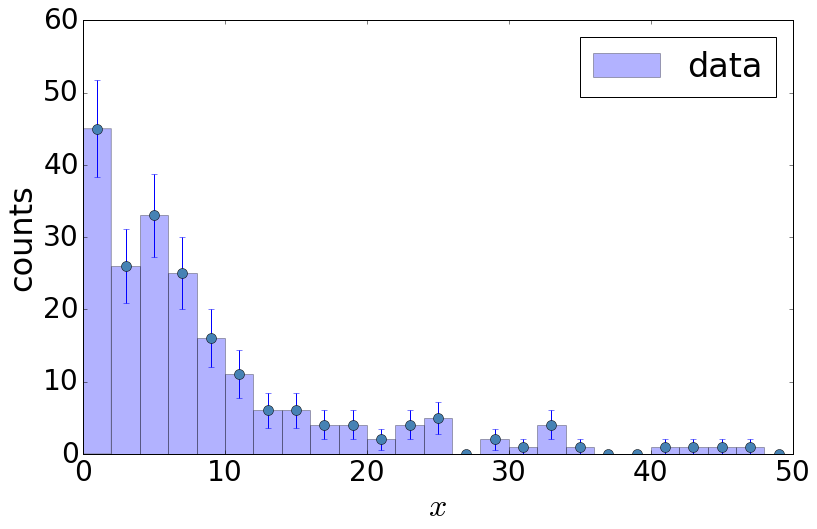

In [6]:
xx, yy  = plotData(data, nbins=25, 
                   xmin=0, xmax=50,
                   ymin=0, ymax=60)

# bin width
h = xx[1]-xx[0] # step size

### Exclude bins with a count less than 5
Note use of __zip__ to zip together two lists __xx__ and __yy__ to form a list  __dd__ of 2-tuples and use __zip(*dd)__ to unzip.

In [7]:
# exclude bins with a count of zero
dd = filter(lambda u: u[-1] > 5, zip(xx, yy))

# unzip into two lists
x, y = zip(*dd)

# convert to numpy array so we can use numpy array operations
x = np.array(x)
y = np.array(y)
m = len(x)
print("number of data points: %d" % m)

number of data points: 8


### Fit model $y = a b \exp(-b x)$ to data
The __scipy__ function
```python
    results = op.least_squares(func, guess, bounds=[lower, upper])
```
where
  * *func* is an $m$-dimensional real function $f_i(\theta)$, $i = 1, \cdots, m,$ with an $n$-dimensional parameter vector $\theta$;
  * *guess* is an initial estimate of the parameter vector $\theta$, and
  * *bounds* contain the lower and upper bounds on the parameter space to be searched,
  
by default, minimizes the function
$$C(\theta) = \frac{1}{2} \sum_{i=1}^m f_i^2(\theta) .$$
In this example, we set $$f_i(\theta) = \left[N_i - n_i(\theta) \right]\sqrt{\frac{2}{N_i}},$$ so
that 
$$C(\theta) = \sum_{i=1}^m \left(\frac{N_i - n_i(\theta)}{\sqrt{N_i}}\right)^2,$$

where $n_i(\theta) = a\int_\textrm{bin$_i$} \exp(-b x) \, dx \approx a \exp(-b x_i) \times h$, with $\theta = a, b$ and $h$ is the bin width. For large $N$, we expect the density of $C$ to be approximately $p(\chi^2, \textrm{ndf})$ with $\textrm{ndf} = m - 2$ degrees of freedom (since there are $m$ bins and two free parameters).

#### Results
The data structure __results__ contains
  * results.x: the fitted parameter values
  * results.cost: $C_\textrm{min}(\theta)$
  * results.jac: the $m \times n$ Jacobian matrix $J = [\partial f_i / \partial \theta_j]$ from which the Hessian can be approximated using $H = J J^\textrm{T}$, which yields an approximation to the covariance matrix $\textrm{Cov} = H^{-1}$.

### Define model to be fitted to data

In [8]:
def func(params):
    a, b = params
    return (y - a * b * np.exp(-b*x) * h) * np.sqrt(2.0/y)

### Perform least squares fit

In [9]:
guess = [50.0, 5.0]    # estimates of a and b
lower = [0.0, 0.0]     # lower bounds of a and b
upper = [500.0, 500.0] # upper bounds of a and b
results = op.least_squares(func, guess, bounds=[lower, upper])

### Get results of fit

In [10]:
a, b  = results.x

# compute approximate covariance matrix
J     = results.jac
cov   = np.linalg.inv(np.dot(J.T, J))
da    = np.sqrt(cov[0][0])
db    = np.sqrt(cov[1][1])

chisq = results.cost
NDF   = m - 2
chisqNDF = chisq/NDF
print('''
a = %6.2f +/- %5.2f
b = %6.2f +/- %5.2f
chisq / NDF = %5.2f / %d = %5.2f
''' % (a, da, b, db, chisq, NDF, chisqNDF))


a = 181.99 +/- 11.10
b =   0.14 +/-  0.01
chisq / NDF =  6.34 / 6 =  1.06



## A bit of statistics

A fit of a model to data returns estimates $\hat{\theta}$ of the model parameters $\theta$, the uncertainty associated with these estimates, and,
ideally, a measure of how well the model fits the data, which is referred to (at least in the frequentist approach) as a 
    *goodness of fit* (gof).
We shall use the gof measure
  $$X = \sum_{i=1}^M \left(\frac{N_i - n_i(\theta)}{\sqrt{N_i}}\right)^2 ,$$
that is, the same function as the one we minimized.

As you learned in the lectures by Eilam Gross, we are really performing an hypothesis test with the crucial difference that we have only a single hypothesis that the fit is *good* and since it is the hypothesis we seek to reject it is the null hypothesis. So, really, a goodness of fit test is testing the badness of the fit, which is quantified using the p-value
$$\textrm{p-value} = P(\chi^2_\textrm{min} > \chi^2).$$



In [11]:
pvalue = 1 - st.chi2.cdf(chisq, NDF)
print('''
p-value of fit: %6.2f
''' % pvalue)


p-value of fit:   0.39



Since the p-value is large, we have no reason to reject the hypothesis that the fit is good.

### Plot results of fit

In [12]:
def plotResult(x, y, params, nbins=25, 
               xmin=0, xmax=50, 
               ymin=0, ymax=60, 
             ftsize=24, 
             color=(0,0,1), 
             fgsize=(12,8)):
    a, b = params
    
    # set size of figure
    plt.figure(figsize=fgsize)
    
    # plot points with simple error bars sqrt(N)
    y_err = [np.sqrt(z) for z in y]
    plt.errorbar(x, y, yerr=y_err, fmt='o', 
                 ecolor='blue', markersize=10,
                 color='steelblue')
    
    h = x[1]-x[0]
    f = a*b*np.exp(-b*x)*h
    plt.plot(x, f, 'r-')
    
    # add legends in order in which plot objects
    # are created
    plt.legend(['fit', 'data'])
    
    # set up x, y limits
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
   
    # add x and y labels
    plt.xlabel('$x$', fontsize=32)
    plt.ylabel('counts', fontsize=32)
    
    # annotate 
    xwid = (xmax-xmin)/10
    ywid = (ymax-ymin)/10

    xpos = 3*xwid
    ypos = 8*ywid
    plt.text(xpos, ypos, 
             r'$a = %6.2f \pm %5.2f$' % (a, da), fontsize=ftsize)
    
    ypos -= ywid
    plt.text(xpos, ypos, 
             r'$b = %6.2f \pm %5.2f$' % (b, db), fontsize=ftsize)
    
    ypos -= ywid
    plt.text(xpos, ypos, 
             r'$\chi^2 \, /\,$ NDF $= %6.2f \, / \, %d$' % (chisq, NDF), 
             fontsize=ftsize)

    ypos -= ywid
    plt.text(xpos, ypos, 
             r'$p$-value = %6.2f' % pvalue, 
             fontsize=ftsize)
 
    # tighten layout so that image is fully
    # contained within viewport
    plt.tight_layout()
    plt.savefig("fig_fit.png")
    plt.show()

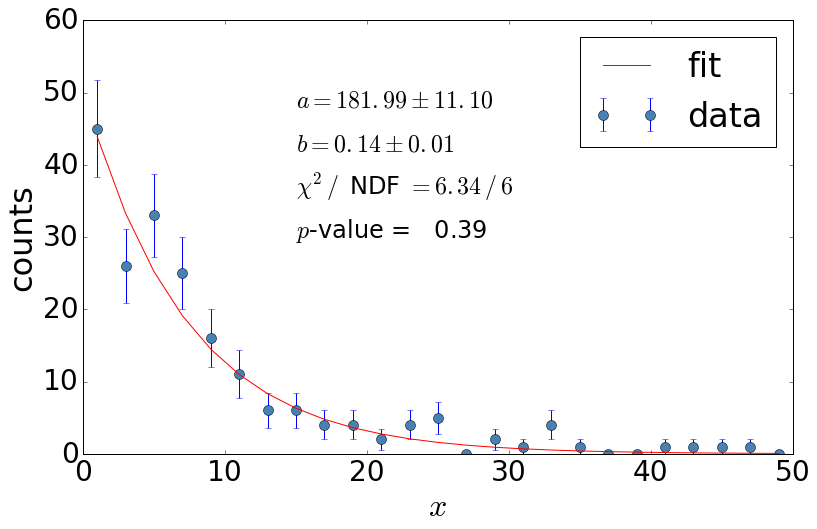

In [13]:
plotResult(xx, yy, results.x, 
           nbins=25, xmin=0, xmax=50, ymin=0, ymax=60)